In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import scipy as sp
import numpy as np
import pySingleCellNet as pySCN
import celloracle as co

import warnings
warnings.filterwarnings(action='once')

co.check_python_requirements()
co.test_R_libraries_installation()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/ubuntu/miniconda3/envs/celloracle_env/lib/python3.8/site-packages/matplotlib_inline/config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


## Q3 - Evaluation of CellOracle Simulation on Wu data

In [2]:
kannan = sc.read('./Kannan_perinatal_reference.h5ad')
kannan

AnnData object with n_obs × n_vars = 936 × 29593
    obs: 'i7', 'cellbarcode', 'column', 'timepoint', 'genes', 'umis', 'ERCC_percent', 'reads'

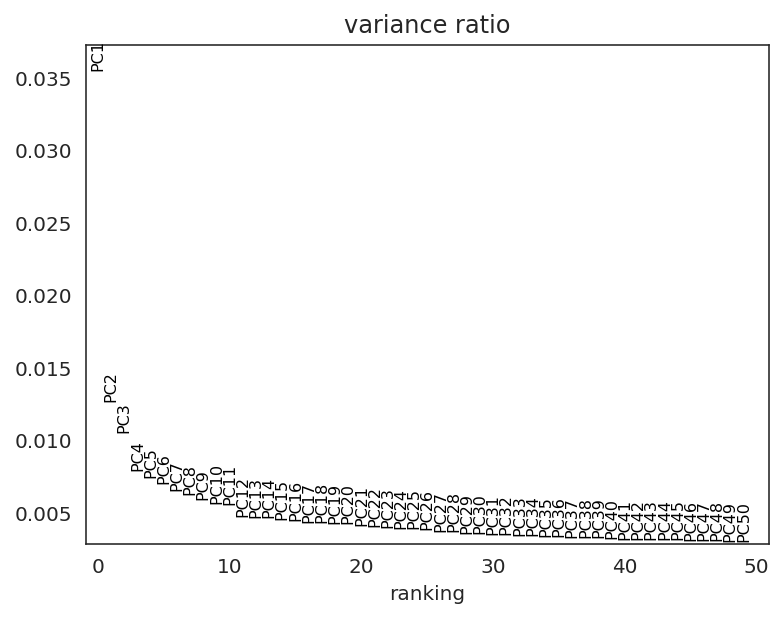

In [3]:
sc.pp.filter_genes(kannan, min_counts=1)
sc.pp.normalize_per_cell(kannan, key_n_counts='n_counts_all')
filter_result = sc.pp.filter_genes_dispersion(kannan.X, flavor='cell_ranger', n_top_genes=2000, log=False)
keep = np.add(filter_result.gene_subset, kannan.var_names=='Prdm16')
kannan = kannan[:, keep]
sc.pp.normalize_per_cell(kannan)
kannan.raw = kannan
kannan.layers["raw_count"] = kannan.raw.X.copy()
sc.pp.log1p(kannan)
sc.pp.scale(kannan)
sc.tl.pca(kannan)
sc.pl.pca_variance_ratio(kannan, 50)

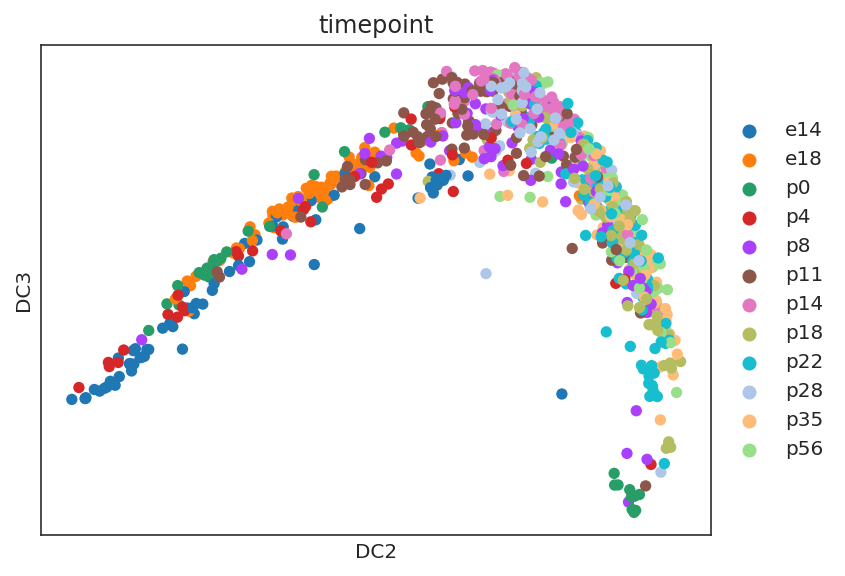

In [4]:
sc.pp.neighbors(kannan, n_neighbors=15, n_pcs=15)
sc.tl.diffmap(kannan)
sc.pl.diffmap(kannan, color='timepoint', components=['2,3'])

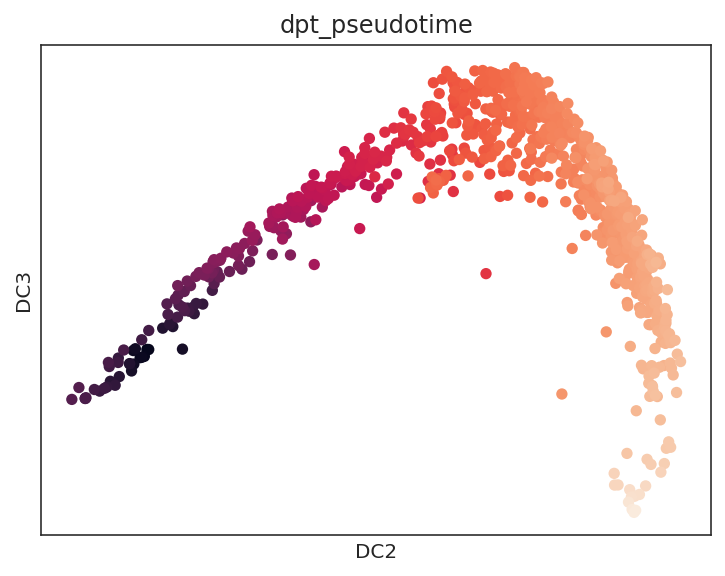

In [5]:
kannan.uns['iroot'] = np.flatnonzero(kannan.obs['timepoint'] == 'e14')[0]
sc.tl.dpt(kannan, n_branchings = 1)
sc.pl.diffmap(kannan, color='dpt_pseudotime', components=['2,3'], use_raw=False, colorbar_loc=None)

In [6]:
# Load cell oracle built-in base GRN from mouse cell atlas dataset
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.head()

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_101006922_101007748,SNORA17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,chr10_101144061_101145000,Mgat4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,chr10_10148873_10149183,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10149425_10149815,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Instantiate Oracle object
oracle = co.Oracle()
kannan.X = kannan.raw.X
oracle.import_anndata_as_raw_count(adata=kannan, cluster_column_name="timepoint", embedding_name="X_pca")

# Load base GRN into oracle object
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [8]:
# Train model on training dataset
oracle.perform_PCA()
n_comps = 50
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

Auto-selected k is :23


In [ ]:
# Calculate GRN for each timepoint 
warnings.filterwarnings('ignore') #Otherwise, np.int nightmare
links = oracle.get_links(cluster_name_for_GRN_unit="timepoint", alpha=10,
                         verbose_level=10, test_mode=False, n_jobs=-1)

  0%|          | 0/12 [00:00<?, ?it/s]

inferring GRN for e14...


  0%|          | 0/1312 [00:00<?, ?it/s]

inferring GRN for e18...


  0%|          | 0/1312 [00:00<?, ?it/s]

inferring GRN for p0...


  0%|          | 0/1312 [00:00<?, ?it/s]

inferring GRN for p11...


  0%|          | 0/1312 [00:00<?, ?it/s]

inferring GRN for p14...


  0%|          | 0/1312 [00:00<?, ?it/s]

inferring GRN for p18...


  0%|          | 0/1312 [00:00<?, ?it/s]

inferring GRN for p22...


  0%|          | 0/1312 [00:00<?, ?it/s]

inferring GRN for p28...


  0%|          | 0/1312 [00:00<?, ?it/s]

inferring GRN for p35...


  0%|          | 0/1312 [00:00<?, ?it/s]

inferring GRN for p4...


  0%|          | 0/1312 [00:00<?, ?it/s]

inferring GRN for p56...


  0%|          | 0/1312 [00:00<?, ?it/s]

inferring GRN for p8...


  0%|          | 0/1312 [00:00<?, ?it/s]

In [10]:
# Filter network edges
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

array([<AxesSubplot:title={'center':'Prdm16'}>], dtype=object)

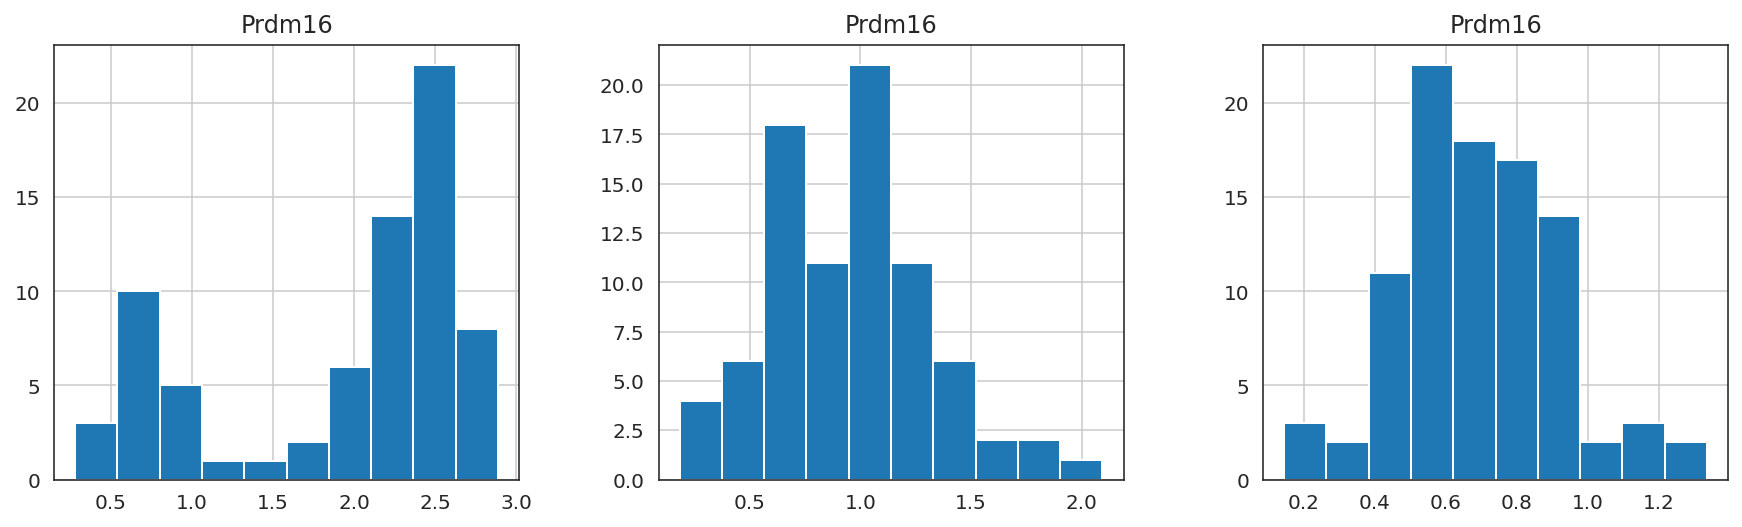

In [11]:
# Plot Prdm16 expression before perturbation
fig, ax = plt.subplots(1, 3, figsize=[15, 4])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'e14'], keys=['Prdm16'], layer="imputed_count").hist(ax=ax[0])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'p8'], keys=['Prdm16'], layer="imputed_count").hist(ax=ax[1])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'p56'], keys=['Prdm16'], layer="imputed_count").hist(ax=ax[2])

In [12]:
# Set Prdm16 expression to zero to stimulate KO
oracle.simulate_shift(perturb_condition={'Prdm16': 0.0}, n_propagation=3)
Prdm16_KO_delta = oracle.adata.layers['delta_X']

array([<AxesSubplot:title={'center':'Prdm16'}>], dtype=object)

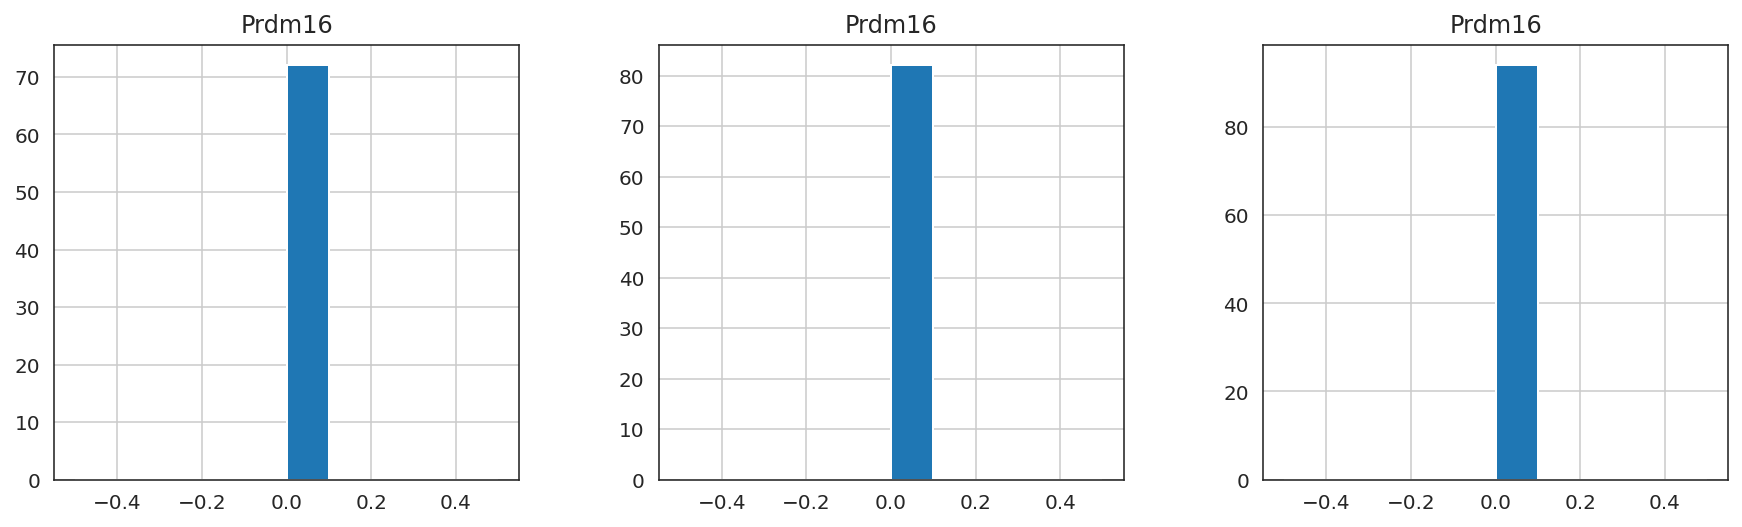

In [ ]:
# Plot Prdm16 expression after perturbation
fig, ax = plt.subplots(1, 3, figsize=[15, 4])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'e14'], keys=['Prdm16'], layer="simulated_count").hist(ax=ax[0])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'p8'], keys=['Prdm16'], layer="simulated_count").hist(ax=ax[1])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'p56'], keys=['Prdm16'], layer="simulated_count").hist(ax=ax[2])

In [16]:
kanan_e14 = oracle.adata[oracle.adata.obs['timepoint'] == 'e14']

In [28]:
kanan_e14.var_names

Index(['H19', 'Narf', 'Xpo6', 'Slfn4', 'Hddc2', 'Egfl6', 'Cttnbp2', 'Cd52',
       'Hip1r', 'Mmp14',
       ...
       'Gm18095', 'Gm49485', 'Gm36677', 'Gm41361', 'Gm49492', 'Gm41386',
       '9430014N10Rik', 'Gm49475', 'Gm30567', 'Gm49463'],
      dtype='object', length=2001)

In [19]:
WU = sc.read_h5ad("wu_prdm16.h5ad")
WU

AnnData object with n_obs × n_vars = 5000 × 32285
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [20]:
WU.obs['type'] = None
WU.obs.loc[WU.obs['sample'] == "WT2", 'type'] = "WT"
WU.obs.loc[WU.obs['sample'] == "WT1", 'type'] = "WT"
WU.obs.loc[WU.obs['sample'] == "Prdm16cKO1", 'type'] = "KO"
WU.obs.loc[WU.obs['sample'] == "Prdm16cKO2", 'type'] = "KO"

In [21]:
sc.pp.log1p(WU)

In [22]:
sc.pp.highly_variable_genes(WU, min_mean = 0.0125, max_mean = 4, min_disp = 0.25)

In [23]:
highly_variable_genes = WU[:, WU.var["highly_variable"] == True]
highly_variable_genes

View of AnnData object with n_obs × n_vars = 5000 × 5129
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'type'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'pca', 'umap', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [24]:
sc.tl.rank_genes_groups(highly_variable_genes, 'type', method='t-test', use_raw = False)

In [27]:
logfoldchange = sc.get.rank_genes_groups_df(highly_variable_genes, group = ['WT'])
logfoldchange = logfoldchange[logfoldchange.pvals_adj < 0.05].sort_values(by = "logfoldchanges", ascending = False)
logfoldchange

,names,scores,logfoldchanges,pvals,pvals_adj
0,Xist,13.237184,1.549860,3.517635e-39,1.804195e-36
20,C1ql3,5.087423,1.232202,3.806446e-07,7.661048e-06
32,Wdr93,4.344594,1.223485,1.429285e-05,1.792372e-04
21,Gpr68,5.009239,0.996368,5.696874e-07,1.102614e-05
44,Asb11,3.666036,0.933230,2.491842e-04,1.969285e-03
...,...,...,...,...,...
5081,Acvr1c,-8.104369,-2.142893,7.097727e-16,6.741526e-14
4839,Shox2,-4.735018,-2.229549,2.270025e-06,3.696177e-05
5126,Ildr2,-16.726152,-2.436303,1.305413e-60,2.231821e-57
5127,Tmem163,-18.260092,-2.705289,3.030680e-71,7.772179e-68


In [32]:
common_genes = list(set(kanan_e14.var_names).intersection(logfoldchange['names'].tolist()))
len(common_genes)

148

In [42]:
wu_foldchange_common = logfoldchange[logfoldchange.names.isin(common_genes)].copy()
wu_foldchange_common

,names,scores,logfoldchanges,pvals,pvals_adj
21,Gpr68,5.009239,0.996368,5.696874e-07,1.102614e-05
19,Pusl1,5.092469,0.893907,3.694843e-07,7.490454e-06
1,Gja1,10.786366,0.840297,8.451156e-27,2.281367e-24
31,Bdh1,4.354387,0.791450,1.364028e-05,1.727432e-04
116,Ptgds,2.775528,0.659462,5.533096e-03,2.288640e-02
...,...,...,...,...,...
4853,Thbs2,-4.840749,-1.384647,1.339575e-06,2.290227e-05
5050,Id4,-7.285542,-1.389386,3.795365e-13,2.246534e-11
4783,Hpgd,-4.492116,-1.564871,7.235878e-06,9.846794e-05
5119,Cttnbp2,-13.079469,-1.666331,2.624971e-38,1.223952e-35


In [66]:
mean_logfoldchange_kanan_e14 = kanan_e14.layers['delta_X'].mean(axis = 0)

In [67]:
geneName_kanan_e14 = kanan_e14.var_names.to_list()
indices = sorted([geneName_kanan_e14.index(gene) for gene in common_genes])

In [68]:
common_logfoldchange_kanan_e14 = mean_logfoldchange_kanan_e14[indices]

In [69]:
import scipy
scipy.stats.pearsonr(common_logfoldchange_kanan_e14, wu_foldchange_common['logfoldchanges'])

(0.03813929464980357, 0.6453597878641945)